In [4]:
#start time 2:41
#end time 3:23

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [5]:
data = pd.read_csv('/content/drive/MyDrive/440/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
print(data.columns)

Index(['review', 'sentiment'], dtype='object')


In [7]:
reviews = data['review']
data['sentiment'] = data['sentiment'].map({'negative': 0, 'positive': 1})
labels = data['sentiment']

In [8]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [9]:
print(data['sentiment'].value_counts())

1    25000
0    25000
Name: sentiment, dtype: int64


In [10]:
# Load GloVe embeddings
def load_glove_embeddings(path):
    embeddings_index = {}
    with open(path) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_path = '/content/drive/MyDrive/440/glove.6B.100d.txt'
glove_embeddings = load_glove_embeddings(glove_path)

In [11]:
# Tokenize and pad sequences

tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(reviews)

sequences = tokenizer.texts_to_sequences(reviews)
word_index = tokenizer.word_index
data_padded = pad_sequences(sequences, maxlen=256)

print(reviews[2])
print(sequences[2])
print(len(data_padded[0]))

I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.
[10, 190, 11, 13, 3, 393, 95, 5, 1155, 55, 20, 3, 96, 879, 1494, 2657, 12

In [12]:
# Prepare GloVe embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [13]:
vocab_size = len(word_index) + 1
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.6044119659082678

In [14]:
# Spliting the data
X_train, X_test, y_train, y_test = train_test_split(data_padded, labels, test_size=0.2, random_state=42)

In [15]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(40000, 256) (10000, 256) (40000,) (10000,)


In [16]:
print(data_padded.shape)

(50000, 256)


In [17]:
#Using Basic ML model
model = LogisticRegression()

model.fit(X_train, y_train)
score = model.score(X_test, y_test)

print('Accuracy', score)

Accuracy 0.519


In [18]:
# Shallow model with dense layers

embedding_dim = 100
vocab_size = len(word_index) + 1

model2 = Sequential()
model2.add(Embedding(vocab_size,
                     embedding_dim,
                     weights=[embedding_matrix],
                     input_length=256,
                     trainable=True))

model2.add(Dense(10, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 100)          12425300  
                                                                 
 dense (Dense)               (None, 256, 10)           1010      
                                                                 
 dense_1 (Dense)             (None, 256, 1)            11        
                                                                 
Total params: 12426321 (47.40 MB)
Trainable params: 12426321 (47.40 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Epoch 1/20
1334/1334 [==============================] - 75s 51ms/step - loss: 0.6867 - accuracy: 0.5303 - val_loss: 0.6846 - val_accuracy: 0.5388
Epoch 2/20
1334/1334 [==============================] - 19s 14ms/step - loss: 0.6844 - accuracy: 0.5361 - val_loss: 0.6843 - val_accuracy: 0.5388
Epoch 3/20
1334/1334 [==============================] - 14s 11ms/step - loss: 0.6842 - accuracy: 0.5366 - val_loss: 0.6845 - val_accuracy: 0.5386
Epoch 4/20
1334/1334 [==============================] - 13s 10ms/step - loss: 0.6842 - accuracy: 0.5366 - val_loss: 0.6841 - val_accuracy: 0.5398
Epoch 5/20
1334/1334 [==============================] - 12s 9ms/step - loss: 0.6841 - accuracy: 0.5370 - val_loss: 0.6842 - val_accuracy: 0.5397
Epoch 6/20
1334/1334 [==============================] - 13s 10ms/step - loss: 0.6840 - accuracy: 0.5370 - val_loss: 0.6841 - val_accuracy: 0.5401
Epoch 7/20
1334/1334 [==============================] - 12s 9ms/step - loss: 0.6839 - accuracy: 0.5377 - val_loss: 0.6844 - v

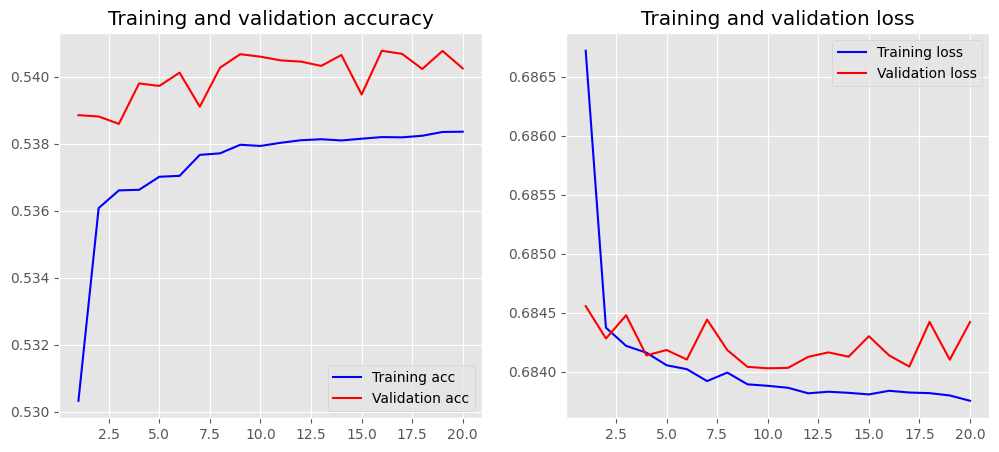

In [20]:
# Train the shallow model
history=model2.fit(X_train, y_train, epochs=20, batch_size=30, validation_data=(X_test, y_test))

# loss2, accuracy2 = model2.evaluate(X_test, y_test)
# print(f'Shallow Model Test Accuracy: {accuracy2}')

loss2,accuracy2 = model2.evaluate(X_train, y_train, verbose = False)
print("Training Accuracy: {:.4f}".format(accuracy2))
loss2,accuracy2 = model2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy2))


plot_history(history)
# accuracy 52 at batch_size 32, trainable = false
# accuracy 53 at batch_size 25, trainable = True
# accuracy 54 at batch_size 30, trainable = False

In [21]:
# LSTM model
model = Sequential()
model.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length=256, trainable=True))
model.add(LSTM(10))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Total params: 12429751 (47.42 MB)
# Trainable params: 4451 (17.39 KB)
# Non-trainable params: 12425300 (47.40 MB)

# Total params: 12429751 (47.42 MB)
# Trainable params: 12429751 (47.42 MB)
# Non-trainable params: 0 (0.00 Byte)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 256, 100)          12425300  
                                                                 
 lstm (LSTM)                 (None, 10)                4440      
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 12429751 (47.42 MB)
Trainable params: 12429751 (47.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/20
1600/1600 [==============================] - 67s 40ms/step - loss: 0.3946 - accuracy: 0.8153 - val_loss: 0.2851 - val_accuracy: 0.8794
Epoch 2/20
1600/1600 [==============================] - 29s 18ms/step - loss: 0.2359 - accuracy: 0.9068 - val_loss: 0.2520 - val_accuracy: 0.8983
Epoch 3/20
1600/1600 [==============================] - 26s 16ms/step - loss: 0.1935 - accuracy: 0.9250 - val_loss: 0.2480 - val_accuracy: 0.8985
Epoch 4/20
1600/1600 [==============================] - 25s 16ms/step - loss: 0.1595 - accuracy: 0.9398 - val_loss: 0.2637 - val_accuracy: 0.8972
Epoch 5/20
1600/1600 [==============================] - 27s 17ms/step - loss: 0.1286 - accuracy: 0.9536 - val_loss: 0.2987 - val_accuracy: 0.8961
Epoch 6/20
1600/1600 [==============================] - 27s 17ms/step - loss: 0.0990 - accuracy: 0.9660 - val_loss: 0.3195 - val_accuracy: 0.8933
Epoch 7/20
1600/1600 [==============================] - 23s 15ms/step - loss: 0.0767 - accuracy: 0.9752 - val_loss: 0.3531 -

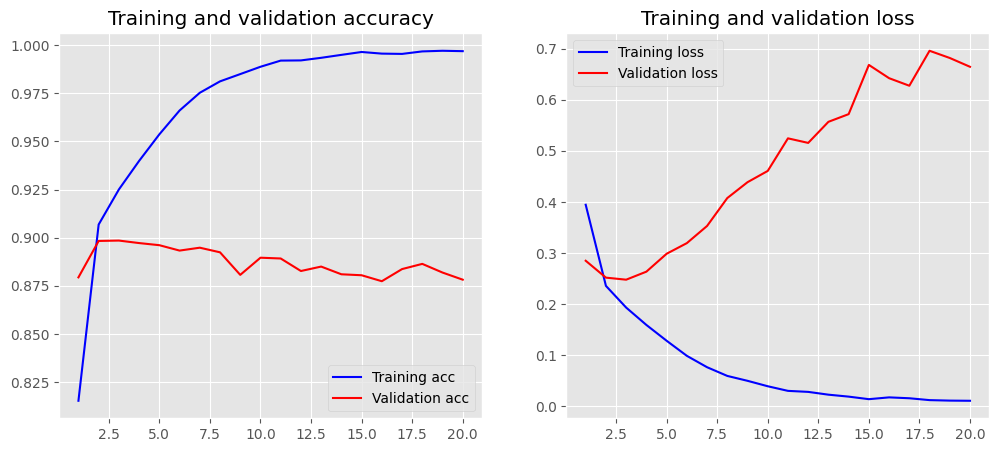

In [22]:
# Train the LSTM model
history2=model.fit(X_train, y_train, epochs=20, batch_size=25, validation_data=(X_test, y_test))

# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'LSTM Model Test Accuracy: {accuracy}')

loss,accuracy = model.evaluate(X_train, y_train, verbose = False)
print("LSTM Model Train Accuracy: {:.4f}".format(accuracy))
loss,accuracy = model.evaluate(X_test, y_test, verbose=False)
print("LSTM Model Test Accuracy {:.4f}".format(accuracy))


plot_history(history2)

# accuracy 85 at batch_size 32, trainable = false
# accuracy 86 at batch_size 32, trainable = false
# accuracy 88 at batch_size 25, trainable = false

In [23]:
# Bidirectional LSTM model
model1 = Sequential()
model1.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length=256, trainable=True))
model1.add(Bidirectional(LSTM(10)))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

# Total params: 12434201 (47.43 MB)
# Trainable params: 8901 (34.77 KB)
# Non-trainable params: 12425300 (47.40 MB)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 256, 100)          12425300  
                                                                 
 bidirectional (Bidirection  (None, 20)                8880      
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 12434201 (47.43 MB)
Trainable params: 12434201 (47.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/20
1600/1600 [==============================] - 79s 47ms/step - loss: 0.4787 - accuracy: 0.7616 - val_loss: 0.2906 - val_accuracy: 0.8813
Epoch 2/20
1600/1600 [==============================] - 43s 27ms/step - loss: 0.2488 - accuracy: 0.9025 - val_loss: 0.2634 - val_accuracy: 0.8929
Epoch 3/20
1600/1600 [==============================] - 38s 24ms/step - loss: 0.2010 - accuracy: 0.9245 - val_loss: 0.2659 - val_accuracy: 0.8965
Epoch 4/20
1600/1600 [==============================] - 38s 24ms/step - loss: 0.1686 - accuracy: 0.9384 - val_loss: 0.2616 - val_accuracy: 0.8939
Epoch 5/20
1600/1600 [==============================] - 37s 23ms/step - loss: 0.1355 - accuracy: 0.9530 - val_loss: 0.2895 - val_accuracy: 0.8930
Epoch 6/20
1600/1600 [==============================] - 42s 26ms/step - loss: 0.1040 - accuracy: 0.9658 - val_loss: 0.3281 - val_accuracy: 0.8928
Epoch 7/20
1600/1600 [==============================] - 39s 24ms/step - loss: 0.0790 - accuracy: 0.9754 - val_loss: 0.3525 -

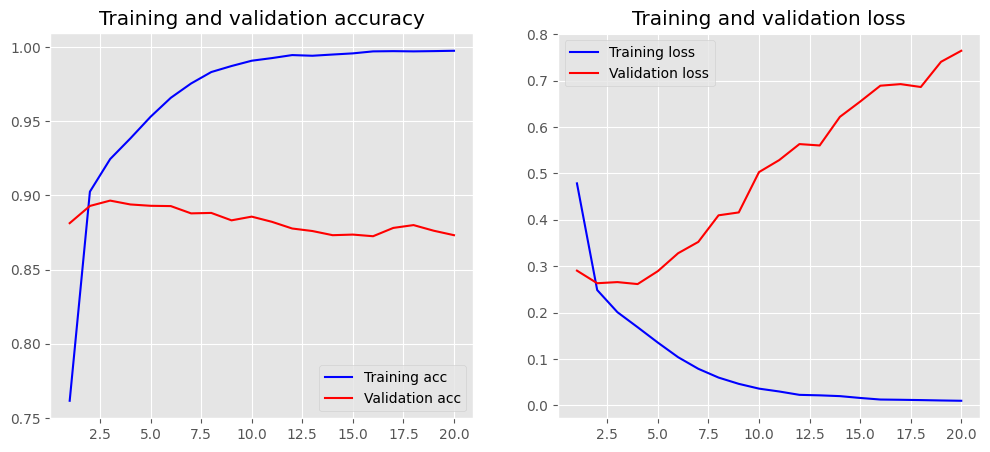

In [24]:
# Train the Bidirectional LSTM model
history3 = model1.fit(X_train, y_train,
                      epochs=20,
                      batch_size=25,
                      validation_data=(X_test, y_test))

# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Bidirectional LSTM Model Test Accuracy: {accuracy}')

loss,accuracy = model1.evaluate(X_train, y_train, verbose = False)
print("LSTM Model Train Accuracy: {:.4f}".format(accuracy))
loss,accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("LSTM Model Test Accuracy {:.4f}".format(accuracy))
plot_history(history3)

# trainable=True
#Bidirectional LSTM Model Train Accuracy: 0.9181
# Bidirectional LSTM Model Test Accuracy 0.8878


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
